# Comparing multiclass LightGBM classifiers for imbalanced darasets

## Imports, utilities

In [5]:
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix,roc_auc_score
import numpy as np

### Plotting confusion matrix

In [6]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
X, y = make_classification(n_classes=3,
                           n_samples=2000, 
                           n_features=2,
                           n_informative=2,
                           n_redundant =0,
                           n_clusters_per_class=1,
                           weights=[.01, .01, .98], 
                           flip_y=.01, 
                           random_state=42)

le = preprocessing.LabelEncoder()
y_label = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.30, random_state=42)

In [8]:
classes =[]
labeles=np.unique(y_label)
for v in labeles:
    classes.append('Class '+ str(v))
print(classes)

['Class 0', 'Class 1', 'Class 2']


## Multiclass lightgbm 

In [11]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train, verbose=0)

LGBMClassifier()

Prediction accuracy 0.99  recall  0.6761904761904761
Normalized confusion matrix
[[0.42857143 0.14285714 0.42857143]
 [0.2        0.6        0.2       ]
 [0.         0.         1.        ]]


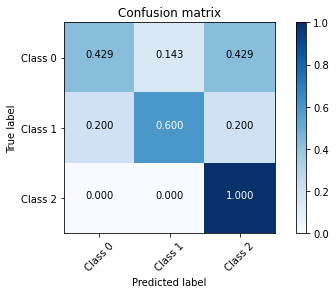

In [12]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)
pred_accuracy_score = accuracy_score(y_test, y_test_pred)
pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print('Prediction accuracy', pred_accuracy_score,' recall ', pred_recall_score)

cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=labeles)
plot_confusion_matrix(cnf_matrix, classes=classes,normalize=True,  title='Confusion matrix')

## Multiclass lightgbm with focal loss

[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 2
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

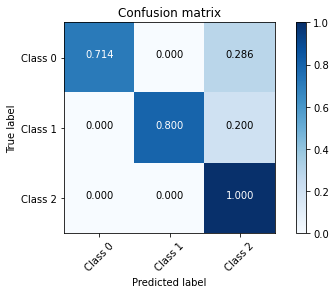

In [13]:
from OneVsRestLightGBMWithCustomizedLoss import *
from FocalLoss import FocalLoss

# Instantiate Focal loss
loss = FocalLoss(alpha=0.75, gamma=2.0)

# Not using early stopping
clf = OneVsRestLightGBMWithCustomizedLoss(loss=loss)
clf.fit(X_train, y_train)

# Using early stopping
#fit_params = {'eval_set': [(X_test, y_test)]}
#clf.fit(X_train, y_train, **fit_params)

y_test_pred = clf.predict(X_test)
pred_accuracy_score = accuracy_score(y_test, y_test_pred)
pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print('prediction accuracy', pred_accuracy_score,' recall ', pred_recall_score)

cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=labeles)
plot_confusion_matrix(cnf_matrix, classes=classes,normalize=True,  title='Confusion matrix')